In [1]:
from power_spectrum import *
from matplotlib.pyplot import *
%matplotlib inline
import tensorflow as tf
import tensorflow_probability as tfp

In [2]:
nsims_train = 10**5
nsims_test = 10**3

batch_size = 64

size=32
k_max=(size/2+1)*2**.5

# Parametrise ps
def pps(par):
    return lambda k: par[int(k/k_max*len(par))]

def training_fn_generator(x,p):
    def f():
        dataset = tf.data.Dataset.from_tensor_slices((x.astype('float32'), p.astype('float32')))
        dataset = dataset.repeat().shuffle(1000).batch(batch_size)
        return dataset
    return f

def testing_fn_generator(x,p):
    def f():
        dataset = tf.data.Dataset.from_tensor_slices((x.astype('float32'), p.astype('float32')))
        dataset = dataset.batch(batch_size)
        return dataset
    return f

In [3]:
import power_spectrum

nbands=2

# sample bandpowers uniformly from [0,1]
p_train = rand(nsims_train,nbands)
p_test = rand(nsims_test,nbands)

x_train = array([field_from_spectrum(pps(p),boxsize=size)[0] for p in p_train])
x_test = array([field_from_spectrum(pps(p),boxsize=size)[0] for p in p_test])

KeyboardInterrupt: 

In [4]:
i=randint(nsims_train)
k1,x1,e1,c1=dynamic_ps(x_train[i])
errorbar(k1,x1,yerr=e1,marker="x",ls="")
critks = arange(nbands+1)*k_max/nbands
for j in range(2):
    axvline(x=critks[j],c="k",ls="--")
    plot(critks[j:j+2],repeat(p_train[i,j],2),c="r")
axvline(x=critks[-1],c="k",ls="--")

NameError: name 'x_train' is not defined

In [5]:
class bandpowers_v1(tf.estimator.Estimator):
    def __init__(self,
                feature_columns,
                label_columns,
                n_mixture=10,
                diag=True,
                optimizer=tf.train.AdamOptimizer,
                activation_fn=tf.nn.relu,
                normalizer_fn=tf.contrib.layers.batch_norm,
                dropout=None,
                model_dir=None,
                config=None):

        def _model_fn(features, labels, mode):
            training=mode == tf.estimator.ModeKeys.TRAIN
            # Builds the neural network
            conv = tf.layers.conv2d(tf.reshape(features,(-1,32,32,1)), 2, 2, strides=2, activation=tf.nn.leaky_relu)
            conv = tf.layers.conv2d(conv, 4, 2, strides=2, activation=tf.nn.leaky_relu)
            conv = tf.layers.conv2d(conv, 8, 2, strides=2, activation=tf.nn.leaky_relu)
            conv = tf.layers.conv2d(conv, 16, 2, strides=2, activation=tf.nn.leaky_relu)
            conv = tf.reshape(tf.layers.conv2d(conv, 32, 2, strides=2, activation=tf.nn.leaky_relu),(-1,32))
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(conv,rate=0.2,training=training),64,activation_fn=tf.nn.leaky_relu)
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=0.2,training=training),16,activation_fn=tf.nn.leaky_relu)
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=0.2,training=training),8,activation_fn=tf.nn.tanh)
            stat = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=0.2,training=training),2,activation_fn=tf.nn.tanh)
            
            net = tf.contrib.layers.fully_connected(stat, 128, activation_fn=tf.nn.leaky_relu)
            
                # Size of the covariance matrix
            label_dimension = len(label_columns)
            if diag ==True:
                size_sigma = label_dimension
            else:
                size_sigma = (label_dimension *(label_dimension +1) // 2)

            # Create mixture components from network output
            out_mu = tf.contrib.layers.fully_connected(net, label_dimension*n_mixture , activation_fn=None)
            out_mu = tf.reshape(out_mu, (-1, n_mixture, label_dimension))

            out_sigma = tf.contrib.layers.fully_connected(net, size_sigma * n_mixture, activation_fn=None)
            out_sigma = tf.reshape(out_sigma, (-1, n_mixture, size_sigma))

            out_p = tf.contrib.layers.fully_connected(net, n_mixture, activation_fn=None)

            if diag == True:
                sigma_mat = tf.nn.softplus(out_sigma)+1e-4
                gmm = tfp.distributions.MixtureSameFamily(mixture_distribution=tfp.distributions.Categorical(logits=out_p),
                              components_distribution=tfp.distributions.MultivariateNormalDiag(loc=out_mu,
                                                                                scale_diag=sigma_mat))
            else:
                sigma_mat = tfp.distributions.matrix_diag_transform(tfp.distributions.fill_triangular(out_sigma), transform=tf.nn.softplus)
                gmm = tfp.distributions.MixtureSameFamily(mixture_distribution=tfp.distributions.Categorical(logits=out_p),
                             components_distribution=tfp.distributions.MultivariateNormalTriL(loc=out_mu,
                                                                                scale_tril=sigma_mat))

            predictions = {'mu': out_mu, 'sigma': sigma_mat, 'p':out_p, 'stat':stat}

            if mode == tf.estimator.ModeKeys.PREDICT:
                y = gmm.sample(2000)
                samples = y
                predictions['samples'] = tf.transpose(y,[1,0,2])

                return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions,
                                                  export_outputs={'pdf': tf.estimator.export.PredictOutput(predictions),
                                                                  'samples': tf.estimator.export.PredictOutput(samples),
                                                                  tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY: tf.estimator.export.PredictOutput(samples)})
            label_layer = labels

            # Compute and register loss function
            loss = - tf.reduce_mean(gmm.log_prob(label_layer),axis=0)
            tf.losses.add_loss(loss)
            total_loss = tf.losses.get_total_loss(add_regularization_losses=True)

            train_op = None
            eval_metric_ops = None

            # Define optimizer
            if mode == tf.estimator.ModeKeys.TRAIN:
                update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
                with tf.control_dependencies(update_ops):
                    train_op = optimizer(learning_rate=0.0002).minimize(loss=total_loss,
                                                global_step=tf.train.get_global_step())
                tf.summary.scalar('loss', loss)
            elif mode == tf.estimator.ModeKeys.EVAL:
                eval_metric_ops = { "log_p": loss}

            return tf.estimator.EstimatorSpec(mode=mode,
                                              predictions=predictions,
                                              loss=total_loss,
                                              train_op=train_op,
                                              eval_metric_ops=eval_metric_ops)

        super(self.__class__, self).__init__(model_fn=_model_fn,
                                             model_dir=model_dir,
                                             config=config)

In [6]:
model = bandpowers_v1(["field"], ["low k","high k"], model_dir='/global/cscratch1/sd/avirukt/models/bp1')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/global/cscratch1/sd/avirukt/models/bp1', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x2aaad69d6860>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [7]:
model.train(training_fn_generator(x_train, p_train*2-1),max_steps=40000)

INFO:tensorflow:Skipping training since max_steps has already saved.


In [8]:
pred = model.predict(testing_fn_generator(x_test, p_test*2-1))
p=next(pred)
i=0

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /global/cscratch1/sd/avirukt/models/bp1/model.ckpt-40000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


Text(0, 0.5, 'power spectrum')

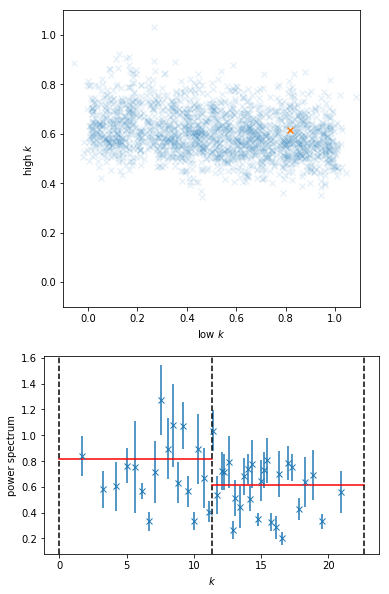

In [9]:
p=next(pred)
i+=1

f,ax=subplots(2,1,gridspec_kw={"height_ratios": (3,2)}, figsize=(6,10))
ax[0].scatter(p["samples"][:,0]/2+.5,p["samples"][:,1]/2+.5,marker="x",alpha=0.1)
ax[0].scatter([p_test[i,0]],[p_test[i,1]],marker="x")
ax[0].set_xlim(-.1,1.1)
ax[0].set_ylim(-.1,1.1)
ax[0].set_aspect("equal")
ax[0].set_xlabel("low $k$")
ax[0].set_ylabel("high $k$")

k1,x1,e1,c1=dynamic_ps(x_test[i])
ax[1].errorbar(k1,x1,yerr=e1,marker="x",ls="")
critks = 0,size/2**1.5,size/2**.5
for j in range(2):
    ax[1].axvline(x=critks[j],c="k",ls="--")
    ax[1].plot(critks[j:j+2],repeat(p_test[i,j],2),c="r")
ax[1].axvline(x=critks[-1],c="k",ls="--")
ax[1].set_xlabel("$k$")
ax[1].set_ylabel("power spectrum")

In [10]:
class bandpowers_v2(tf.estimator.Estimator):
    def __init__(self,
                feature_columns,
                label_columns,
                n_mixture=10,
                diag=True,
                optimizer=tf.train.AdamOptimizer,
                activation_fn=tf.nn.relu,
                normalizer_fn=tf.contrib.layers.batch_norm,
                dropout=None,
                model_dir=None,
                config=None):

        def _model_fn(features, labels, mode):
            training=mode == tf.estimator.ModeKeys.TRAIN
            # Builds the neural network
            conv = tf.layers.conv2d(tf.reshape(features,(-1,32,32,1)), 4, 2, strides=2, activation=tf.nn.leaky_relu)
            conv = tf.layers.conv2d(conv, 16, 2, strides=2, activation=tf.nn.leaky_relu)
            conv = tf.layers.conv2d(conv, 64, 2, strides=2, activation=tf.nn.leaky_relu)
            conv = tf.layers.conv2d(conv, 128, 2, strides=2, activation=tf.nn.leaky_relu)
            conv = tf.reshape(tf.layers.conv2d(conv, 256, 2, strides=2, activation=tf.nn.leaky_relu),(-1,256))
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(conv,rate=0.2,training=training),128,activation_fn=tf.nn.leaky_relu)
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=0.2,training=training),32,activation_fn=tf.nn.leaky_relu)
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=0.2,training=training),8,activation_fn=tf.nn.tanh)
            stat = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=0.2,training=training),2,activation_fn=tf.nn.tanh)
            
            net = tf.contrib.layers.fully_connected(stat, 128, activation_fn=tf.nn.leaky_relu)
            
                # Size of the covariance matrix
            label_dimension = len(label_columns)
            if diag ==True:
                size_sigma = label_dimension
            else:
                size_sigma = (label_dimension *(label_dimension +1) // 2)

            # Create mixture components from network output
            out_mu = tf.contrib.layers.fully_connected(net, label_dimension*n_mixture , activation_fn=None)
            out_mu = tf.reshape(out_mu, (-1, n_mixture, label_dimension))

            out_sigma = tf.contrib.layers.fully_connected(net, size_sigma * n_mixture, activation_fn=None)
            out_sigma = tf.reshape(out_sigma, (-1, n_mixture, size_sigma))

            out_p = tf.contrib.layers.fully_connected(net, n_mixture, activation_fn=None)

            if diag == True:
                sigma_mat = tf.nn.softplus(out_sigma)+1e-4
                gmm = tfp.distributions.MixtureSameFamily(mixture_distribution=tfp.distributions.Categorical(logits=out_p),
                              components_distribution=tfp.distributions.MultivariateNormalDiag(loc=out_mu,
                                                                                scale_diag=sigma_mat))
            else:
                sigma_mat = tfp.distributions.matrix_diag_transform(tfp.distributions.fill_triangular(out_sigma), transform=tf.nn.softplus)
                gmm = tfp.distributions.MixtureSameFamily(mixture_distribution=tfp.distributions.Categorical(logits=out_p),
                             components_distribution=tfp.distributions.MultivariateNormalTriL(loc=out_mu,
                                                                                scale_tril=sigma_mat))

            predictions = {'mu': out_mu, 'sigma': sigma_mat, 'p':out_p, 'stat':stat}

            if mode == tf.estimator.ModeKeys.PREDICT:
                y = gmm.sample(2000)
                samples = y
                predictions['samples'] = tf.transpose(y,[1,0,2])

                return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions,
                                                  export_outputs={'pdf': tf.estimator.export.PredictOutput(predictions),
                                                                  'samples': tf.estimator.export.PredictOutput(samples),
                                                                  tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY: tf.estimator.export.PredictOutput(samples)})
            label_layer = labels

            # Compute and register loss function
            loss = - tf.reduce_mean(gmm.log_prob(label_layer),axis=0)
            tf.losses.add_loss(loss)
            total_loss = tf.losses.get_total_loss(add_regularization_losses=True)

            train_op = None
            eval_metric_ops = None

            # Define optimizer
            if mode == tf.estimator.ModeKeys.TRAIN:
                update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
                with tf.control_dependencies(update_ops):
                    train_op = optimizer(learning_rate=0.0002).minimize(loss=total_loss,
                                                global_step=tf.train.get_global_step())
                tf.summary.scalar('loss', loss)
            elif mode == tf.estimator.ModeKeys.EVAL:
                eval_metric_ops = { "log_p": loss}

            return tf.estimator.EstimatorSpec(mode=mode,
                                              predictions=predictions,
                                              loss=total_loss,
                                              train_op=train_op,
                                              eval_metric_ops=eval_metric_ops)

        super(self.__class__, self).__init__(model_fn=_model_fn,
                                             model_dir=model_dir,
                                             config=config)
    
model = bandpowers_v2(["field"], ["low k","high k"], model_dir='/global/cscratch1/sd/avirukt/models/bp2')
model.train(training_fn_generator(x_train, p_train*2-1),max_steps=40000)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/global/cscratch1/sd/avirukt/models/bp2', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x2aabb7e83ba8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Skipping training since max_steps has already saved.


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /global/cscratch1/sd/avirukt/models/bp2/model.ckpt-40000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


Text(0.5, 0.98, 'Summary statistics')

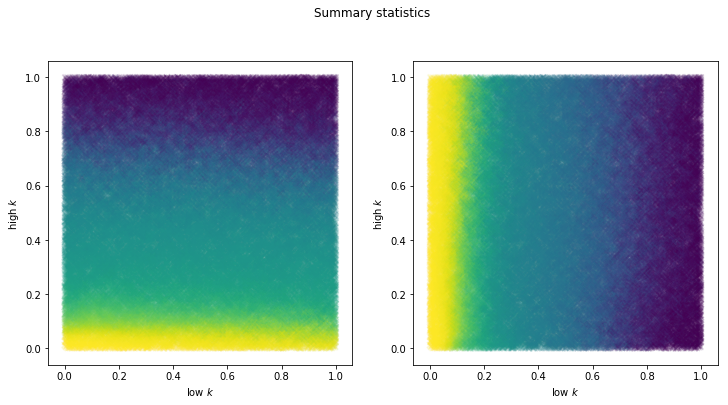

In [11]:
stats = array([p["stat"] for p in model.predict(testing_fn_generator(x_train, p_train*2-1))])
f,ax = subplots(1,2,figsize=(12,6))
ax[0].scatter(p_train[:,0],p_train[:,1],c=stats[:,0],marker="x",alpha=0.1)
ax[0].set_aspect("equal")
ax[0].set_xlabel("low $k$")
ax[0].set_ylabel("high $k$")
ax[1].scatter(p_train[:,0],p_train[:,1],c=stats[:,1],marker="x",alpha=0.1)
ax[1].set_aspect("equal")
ax[1].set_xlabel("low $k$")
ax[1].set_ylabel("high $k$")
suptitle("Summary statistics")

In [12]:
pred = model.predict(testing_fn_generator(x_test, p_test*2-1))
p=next(pred)
i=0

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /global/cscratch1/sd/avirukt/models/bp2/model.ckpt-40000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


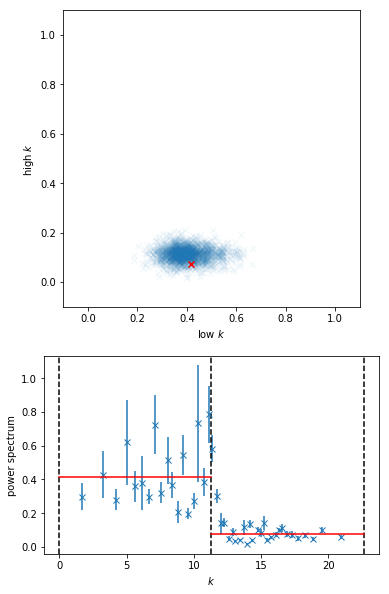

In [13]:
f,ax=subplots(2,1,gridspec_kw={"height_ratios": (3,2)}, figsize=(6,10))
ax[0].scatter(p["samples"][:,0]/2+.5,p["samples"][:,1]/2+.5,marker="x",alpha=0.05,label="MDN")
ax[0].scatter([p_test[i,0]],[p_test[i,1]],marker="x",label="truth",c="r")
ax[0].set_xlim(-.1,1.1)
ax[0].set_ylim(-.1,1.1)
ax[0].set_aspect("equal")
ax[0].set_xlabel("low $k$")
ax[0].set_ylabel("high $k$")
#ax[0].legend()

k1,x1,e1,c1=dynamic_ps(x_test[i])
ax[1].errorbar(k1,x1,yerr=e1,marker="x",ls="")
critks = 0,size/2**1.5,size/2**.5
for j in range(2):
    ax[1].axvline(x=critks[j],c="k",ls="--")
    ax[1].errorbar(critks[j:j+2],repeat(p_test[i,j],2),c="r",marker="")
ax[1].axvline(x=critks[-1],c="k",ls="--")
ax[1].set_xlabel("$k$")
ax[1].set_ylabel("power spectrum")

p=next(pred)
i+=1

In [14]:
class bandpowers_v3(tf.estimator.Estimator):
    def __init__(self,
                feature_columns,
                label_columns,
                n_mixture=10,
                diag=False,
                optimizer=tf.train.AdamOptimizer,
                activation_fn=tf.nn.relu,
                normalizer_fn=tf.contrib.layers.batch_norm,
                dropout=None,
                model_dir=None,
                config=None):

        def _model_fn(features, labels, mode):
            training=mode == tf.estimator.ModeKeys.TRAIN
            # Builds the neural network
            conv = tf.layers.conv2d(tf.reshape(features,(-1,32,32,1)), 4, 2, strides=2, activation=tf.nn.leaky_relu)
            conv = tf.layers.conv2d(conv, 16, 2, strides=2, activation=tf.nn.leaky_relu)
            conv = tf.layers.conv2d(conv, 64, 2, strides=2, activation=tf.nn.leaky_relu)
            conv = tf.layers.conv2d(conv, 128, 2, strides=2, activation=tf.nn.leaky_relu)
            conv = tf.reshape(tf.layers.conv2d(conv, 256, 2, strides=2, activation=tf.nn.leaky_relu),(-1,256))
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(conv,rate=0.2,training=training),128,activation_fn=tf.nn.leaky_relu)
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=0.2,training=training),32,activation_fn=tf.nn.leaky_relu)
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=0.2,training=training),8,activation_fn=tf.nn.tanh)
            stat = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=0.2,training=training),2,activation_fn=tf.nn.tanh)
            
            net = tf.contrib.layers.fully_connected(stat, 128, activation_fn=tf.nn.leaky_relu)
            
                # Size of the covariance matrix
            label_dimension = len(label_columns)
            if diag ==True:
                size_sigma = label_dimension
            else:
                size_sigma = (label_dimension *(label_dimension +1) // 2)

            # Create mixture components from network output
            out_mu = tf.contrib.layers.fully_connected(net, label_dimension*n_mixture , activation_fn=None)
            out_mu = tf.reshape(out_mu, (-1, n_mixture, label_dimension))

            out_sigma = tf.contrib.layers.fully_connected(net, size_sigma * n_mixture, activation_fn=None)
            out_sigma = tf.reshape(out_sigma, (-1, n_mixture, size_sigma))

            out_p = tf.contrib.layers.fully_connected(net, n_mixture, activation_fn=None)

            if diag == True:
                sigma_mat = tf.nn.softplus(out_sigma)+1e-4
                gmm = tfp.distributions.MixtureSameFamily(mixture_distribution=tfp.distributions.Categorical(logits=out_p),
                              components_distribution=tfp.distributions.MultivariateNormalDiag(loc=out_mu,
                                                                                scale_diag=sigma_mat))
            else:
                sigma_mat = tfp.distributions.matrix_diag_transform(tfp.distributions.fill_triangular(out_sigma), transform=tf.nn.softplus)
                gmm = tfp.distributions.MixtureSameFamily(mixture_distribution=tfp.distributions.Categorical(logits=out_p),
                             components_distribution=tfp.distributions.MultivariateNormalTriL(loc=out_mu,
                                                                                scale_tril=sigma_mat))

            predictions = {'mu': out_mu, 'sigma': sigma_mat, 'p':out_p, 'stat':stat}

            if mode == tf.estimator.ModeKeys.PREDICT:
                y = gmm.sample(2000)
                samples = y
                predictions['samples'] = tf.transpose(y,[1,0,2])

                return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions,
                                                  export_outputs={'pdf': tf.estimator.export.PredictOutput(predictions),
                                                                  'samples': tf.estimator.export.PredictOutput(samples),
                                                                  tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY: tf.estimator.export.PredictOutput(samples)})
            label_layer = labels

            # Compute and register loss function
            loss = - tf.reduce_mean(gmm.log_prob(label_layer),axis=0)
            tf.losses.add_loss(loss)
            total_loss = tf.losses.get_total_loss(add_regularization_losses=True)

            train_op = None
            eval_metric_ops = None

            # Define optimizer
            if mode == tf.estimator.ModeKeys.TRAIN:
                update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
                with tf.control_dependencies(update_ops):
                    train_op = optimizer(learning_rate=0.0002).minimize(loss=total_loss,
                                                global_step=tf.train.get_global_step())
                tf.summary.scalar('loss', loss)
            elif mode == tf.estimator.ModeKeys.EVAL:
                eval_metric_ops = { "log_p": loss}

            return tf.estimator.EstimatorSpec(mode=mode,
                                              predictions=predictions,
                                              loss=total_loss,
                                              train_op=train_op,
                                              eval_metric_ops=eval_metric_ops)

        super(self.__class__, self).__init__(model_fn=_model_fn,
                                             model_dir=model_dir,
                                             config=config)
    
model = bandpowers_v3(["field"], ["low k","high k"], model_dir='/global/cscratch1/sd/avirukt/models/bp3')
model.train(training_fn_generator(x_train, p_train*2-1),max_steps=40000)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/global/cscratch1/sd/avirukt/models/bp3', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x2aacdcc52518>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Skipping training since max_steps has already saved.


In [15]:
pred = model.predict(testing_fn_generator(x_test, p_test*2-1))
p=next(pred)
i=0

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /global/cscratch1/sd/avirukt/models/bp3/model.ckpt-40000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


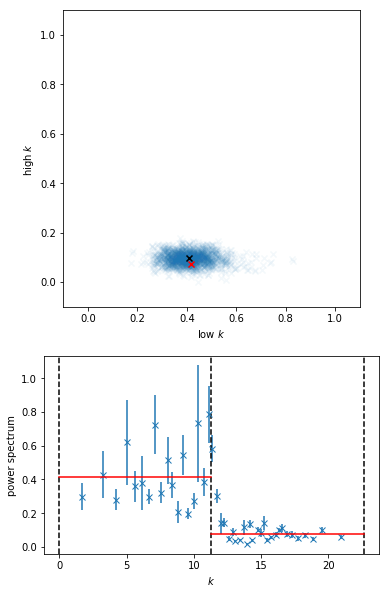

In [16]:
f,ax=subplots(2,1,gridspec_kw={"height_ratios": (3,2)}, figsize=(6,10))
ax[0].scatter(p["samples"][:,0]/2+.5,p["samples"][:,1]/2+.5,marker="x",alpha=0.05,label="MDN")
ax[0].scatter(*mean(p["samples"]/2+.5,axis=0),marker="x",c="k")
ax[0].scatter(p_test[i,0],p_test[i,1],marker="x",label="truth",c="r")
ax[0].set_xlim(-.1,1.1)
ax[0].set_ylim(-.1,1.1)
ax[0].set_aspect("equal")
ax[0].set_xlabel("low $k$")
ax[0].set_ylabel("high $k$")
#ax[0].legend()

k1,x1,e1,c1=dynamic_ps(x_test[i])
ax[1].errorbar(k1,x1,yerr=e1,marker="x",ls="")
critks = 0,size/2**1.5,size/2**.5
for j in range(2):
    ax[1].axvline(x=critks[j],c="k",ls="--")
    ax[1].errorbar(critks[j:j+2],repeat(p_test[i,j],2),c="r",marker="")
ax[1].axvline(x=critks[-1],c="k",ls="--")
ax[1].set_xlabel("$k$")
ax[1].set_ylabel("power spectrum")

p=next(pred)
i+=1

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /global/cscratch1/sd/avirukt/models/bp3/model.ckpt-40000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


Text(0.5, 0, 'high $k$')

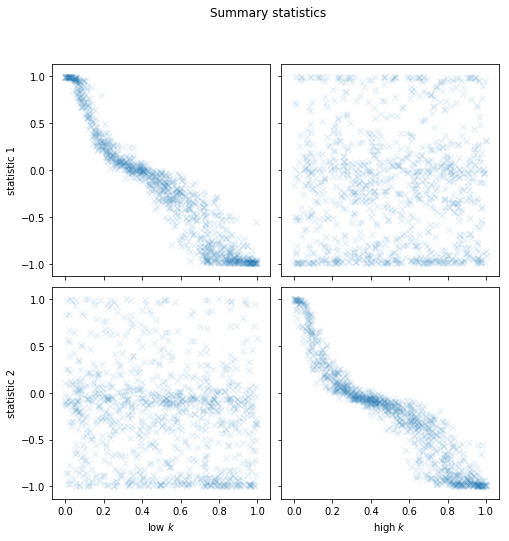

In [17]:
stats = array([p["stat"] for p in model.predict(testing_fn_generator(x_test, p_test*2-1))])
f,ax = subplots(nbands,nbands,sharex=True,sharey=True,gridspec_kw={"hspace": 0.05, "wspace": 0.05},figsize=(4*nbands,4*nbands))
#statlabels
suptitle("Summary statistics")
for i in range(nbands):
    for j in range(nbands):
        ax[i,j].scatter(p_test[:,j],stats[:,i],marker="x",alpha=0.1)
for i in range(nbands):
    ax[i,0].set_ylabel(f"statistic {i+1}")
ax[-1,0].set_xlabel("low $k$")
ax[-1,-1].set_xlabel("high $k$")

In [3]:
%%time

nbands=4

# sample bandpowers uniformly from [0,1]
p_train = rand(nsims_train,nbands)
p_test = rand(nsims_test,nbands)

x_train = array([field_from_spectrum(pps(p),boxsize=size)[0] for p in p_train])
x_test = array([field_from_spectrum(pps(p),boxsize=size)[0] for p in p_test])

CPU times: user 0 ns, sys: 12.2 ms, total: 12.2 ms
Wall time: 10.5 ms


In [19]:
class bandpowers_v3_4b(tf.estimator.Estimator):
    def __init__(self,
                feature_columns,
                label_columns,
                n_mixture=10,
                diag=False,
                optimizer=tf.train.AdamOptimizer,
                activation_fn=tf.nn.relu,
                normalizer_fn=tf.contrib.layers.batch_norm,
                dropout=None,
                model_dir=None,
                config=None):

        def _model_fn(features, labels, mode):
            training=mode == tf.estimator.ModeKeys.TRAIN
            # Builds the neural network
            conv = tf.layers.conv2d(tf.reshape(features,(-1,32,32,1)), 4, 2, strides=2, activation=tf.nn.leaky_relu)
            conv = tf.layers.conv2d(conv, 16, 2, strides=2, activation=tf.nn.leaky_relu)
            conv = tf.layers.conv2d(conv, 64, 2, strides=2, activation=tf.nn.leaky_relu)
            conv = tf.layers.conv2d(conv, 128, 2, strides=2, activation=tf.nn.leaky_relu)
            conv = tf.reshape(tf.layers.conv2d(conv, 256, 2, strides=2, activation=tf.nn.leaky_relu),(-1,256))
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(conv,rate=0.2,training=training),128,activation_fn=tf.nn.leaky_relu)
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=0.2,training=training),32,activation_fn=tf.nn.leaky_relu)
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=0.2,training=training),8,activation_fn=tf.nn.tanh)
            stat = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=0.2,training=training),4,activation_fn=tf.nn.tanh)
            
            net = tf.contrib.layers.fully_connected(stat, 128, activation_fn=tf.nn.leaky_relu)
            
                # Size of the covariance matrix
            label_dimension = len(label_columns)
            if diag ==True:
                size_sigma = label_dimension
            else:
                size_sigma = (label_dimension *(label_dimension +1) // 2)

            # Create mixture components from network output
            out_mu = tf.contrib.layers.fully_connected(net, label_dimension*n_mixture , activation_fn=None)
            out_mu = tf.reshape(out_mu, (-1, n_mixture, label_dimension))

            out_sigma = tf.contrib.layers.fully_connected(net, size_sigma * n_mixture, activation_fn=None)
            out_sigma = tf.reshape(out_sigma, (-1, n_mixture, size_sigma))

            out_p = tf.contrib.layers.fully_connected(net, n_mixture, activation_fn=None)

            if diag == True:
                sigma_mat = tf.nn.softplus(out_sigma)+1e-4
                gmm = tfp.distributions.MixtureSameFamily(mixture_distribution=tfp.distributions.Categorical(logits=out_p),
                              components_distribution=tfp.distributions.MultivariateNormalDiag(loc=out_mu,
                                                                                scale_diag=sigma_mat))
            else:
                sigma_mat = tfp.distributions.matrix_diag_transform(tfp.distributions.fill_triangular(out_sigma), transform=tf.nn.softplus)
                gmm = tfp.distributions.MixtureSameFamily(mixture_distribution=tfp.distributions.Categorical(logits=out_p),
                             components_distribution=tfp.distributions.MultivariateNormalTriL(loc=out_mu,
                                                                                scale_tril=sigma_mat))

            predictions = {'mu': out_mu, 'sigma': sigma_mat, 'p':out_p, 'stat':stat}

            if mode == tf.estimator.ModeKeys.PREDICT:
                y = gmm.sample(2000)
                samples = y
                predictions['samples'] = tf.transpose(y,[1,0,2])

                return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions,
                                                  export_outputs={'pdf': tf.estimator.export.PredictOutput(predictions),
                                                                  'samples': tf.estimator.export.PredictOutput(samples),
                                                                  tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY: tf.estimator.export.PredictOutput(samples)})
            label_layer = labels

            # Compute and register loss function
            loss = - tf.reduce_mean(gmm.log_prob(label_layer),axis=0)
            tf.losses.add_loss(loss)
            total_loss = tf.losses.get_total_loss(add_regularization_losses=True)

            train_op = None
            eval_metric_ops = None

            # Define optimizer
            if mode == tf.estimator.ModeKeys.TRAIN:
                update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
                with tf.control_dependencies(update_ops):
                    train_op = optimizer(learning_rate=0.0002).minimize(loss=total_loss,
                                                global_step=tf.train.get_global_step())
                tf.summary.scalar('loss', loss)
            elif mode == tf.estimator.ModeKeys.EVAL:
                eval_metric_ops = { "log_p": loss}

            return tf.estimator.EstimatorSpec(mode=mode,
                                              predictions=predictions,
                                              loss=total_loss,
                                              train_op=train_op,
                                              eval_metric_ops=eval_metric_ops)

        super(self.__class__, self).__init__(model_fn=_model_fn,
                                             model_dir=model_dir,
                                             config=config)
    
model = bandpowers_v3_4b(["field"], ["low k","x","y","high k"], model_dir='/global/cscratch1/sd/avirukt/models/bp5')
model.train(training_fn_generator(x_train, p_train*2-1),max_steps=70*nsims_train//batch_size)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/global/cscratch1/sd/avirukt/models/bp5', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x2aacdd527048>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
I

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /global/cscratch1/sd/avirukt/models/bp5/model.ckpt-109375
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


Text(0.5, 0, 'high $k$')

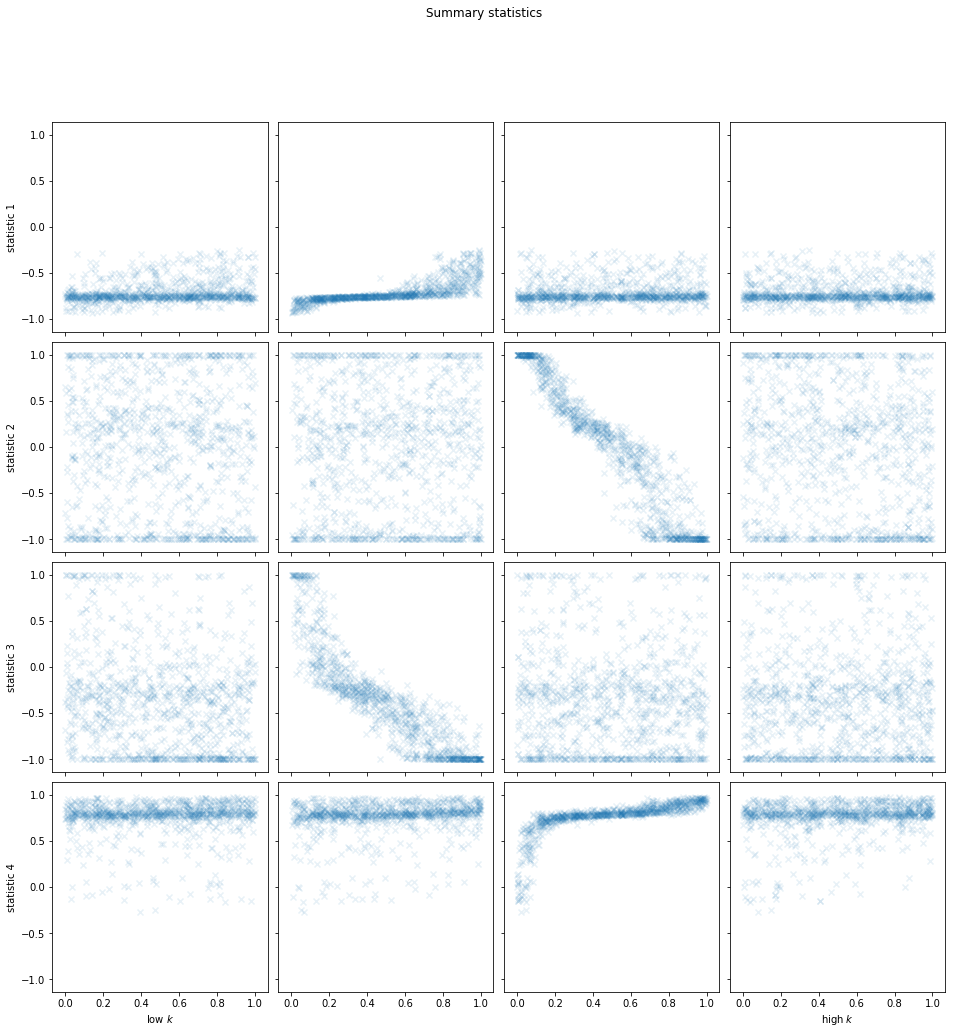

In [20]:
stats = array([p["stat"] for p in model.predict(testing_fn_generator(x_test, p_test))])
f,ax = subplots(nbands,nbands,sharex=True,sharey=True,gridspec_kw={"hspace": 0.05, "wspace": 0.05},figsize=(4*nbands,4*nbands))
#statlabels
suptitle("Summary statistics")
for i in range(nbands):
    for j in range(nbands):
        ax[i,j].scatter(p_test[:,j],stats[:,i],marker="x",alpha=0.1)
for i in range(nbands):
    ax[i,0].set_ylabel(f"statistic {i+1}")
ax[-1,0].set_xlabel("low $k$")
ax[-1,-1].set_xlabel("high $k$")

In [21]:
pred = model.predict(testing_fn_generator(x_test, p_test*2-1))
p=next(pred)
k=0

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /global/cscratch1/sd/avirukt/models/bp5/model.ckpt-109375
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


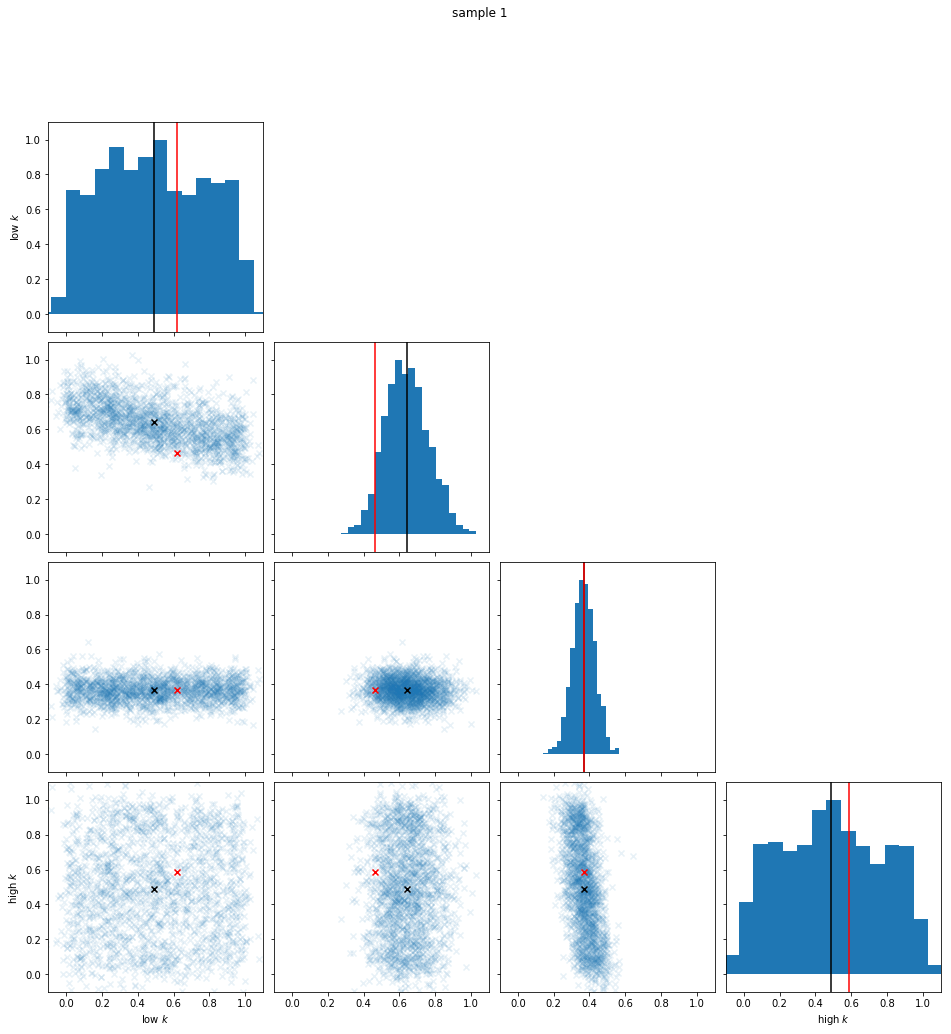

In [22]:
f,ax = subplots(nbands,nbands,sharex=True,sharey=True,gridspec_kw={"hspace": 0.05, "wspace": 0.05},figsize=(4*nbands,4*nbands))
suptitle(f"sample {k+1}")
samples= p["samples"]/2+.5
mn_s = mean(samples,axis=0)
for i in range(nbands):
    ax[i,i].set_ylim(-.1,1.1)
    ax[i,i].set_xlim(-.1,1.1)
    counts,edges,patches=ax[i,i].hist(samples[:,i],bins=20)
    top = amax(counts)
    for count,patch in zip(counts,patches):
        patch.set_height(count/top)
    ax[i,i].axvline(x=mn_s[i],c="k")
    ax[i,i].axvline(x=p_test[k,i],c="r")
    for j in range(i):
        ax[i,j].scatter(samples[:,j],samples[:,i],marker="x",alpha=0.1)
        ax[i,j].scatter(p_test[k,j],p_test[k,i],marker="x",c="r")
        ax[i,j].scatter(mn_s[j],mn_s[i],marker="x",c="k")
        ax[-(i+1),-(j+1)].axis("off")
ax[-1,0].set_xlabel("low $k$")
ax[-1,-1].set_xlabel("high $k$")
ax[0,0].set_ylabel("low $k$")
ax[-1,0].set_ylabel("high $k$")
p=next(pred)
k+=1

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /global/cscratch1/sd/avirukt/models/bp5/model.ckpt-109375
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


Text(0.5, 0, 'high $k$')

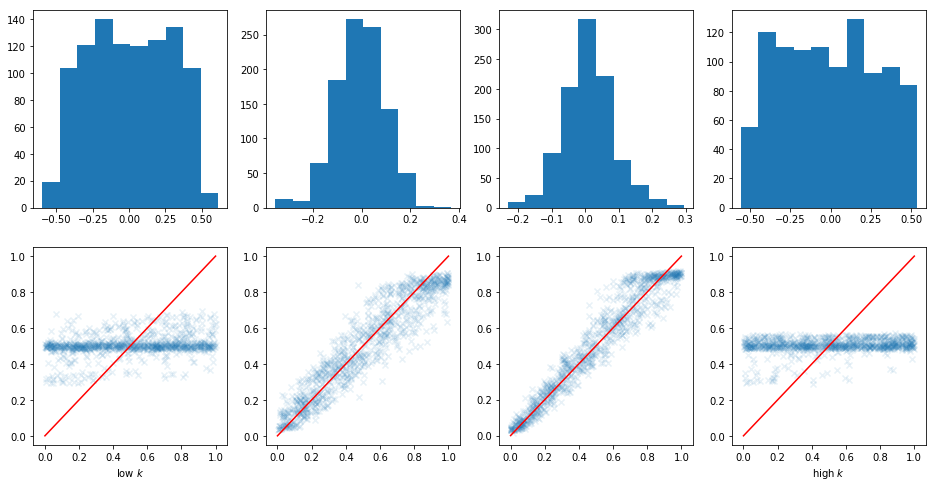

In [23]:
cnn_pred = array([mean(p["samples"],axis=0) for p in model.predict(testing_fn_generator(x_test, p_test))])/2+.5
ps_pred = array([equal_spacing_ps(x,k_max/nbands) for x in p_test])
f,ax=subplots(2,nbands,figsize=(4*nbands,8))
for i in range(nbands):
    ax[0,i].hist(cnn_pred[:,i]-p_test[:,i])
    ax[1,i].plot([0,1],[0,1],c="r")
    ax[1,i].scatter(p_test[:,i],ps_pred[:,i],marker="x",alpha=0.1,c="k")
    ax[1,i].scatter(p_test[:,i],cnn_pred[:,i],marker="x",alpha=0.1)
ax[1,0].set_xlabel("low $k$")
ax[1,-1].set_xlabel("high $k$")

In [4]:
k,f=get_flt_k_f(field_from_spectrum(lambda x: x, size)[0])
ind,e=bin_by_count(k,253)
critks=[0.5*(k[ind[j][-1]]+k[ind[j+1][0]]) for j in range(nbands-1)]
critks=array([0]+critks+[(size/2+1)*2**.5])
print(critks,[len(i) for i in ind])

[ 0.          9.02769257 12.76708527 15.6364876  24.04163056] [253, 256, 260, 255]


In [5]:
def pps(par):
    return lambda k: par[argmax(critks>=k)-1]

In [6]:
%%time

x_train = array([field_from_spectrum(pps(p),boxsize=size)[0] for p in p_train])
x_test = array([field_from_spectrum(pps(p),boxsize=size)[0] for p in p_test])

CPU times: user 20min 25s, sys: 2.26 s, total: 20min 27s
Wall time: 10min 13s


In [27]:
class bandpowers_v4_4b(tf.estimator.Estimator):
    def __init__(self,
                feature_columns,
                label_columns,
                n_mixture=10,
                diag=False,
                optimizer=tf.train.AdamOptimizer,
                activation_fn=tf.nn.relu,
                normalizer_fn=tf.contrib.layers.batch_norm,
                dropout=None,
                model_dir=None,
                config=None):

        def _model_fn(features, labels, mode):
            training=mode == tf.estimator.ModeKeys.TRAIN
            # Builds the neural network
            conv = tf.layers.conv2d(tf.reshape(features,(-1,32,32,1)), 4, 2, strides=2, activation=tf.nn.leaky_relu)
            conv = tf.layers.conv2d(conv, 16, 2, strides=2, activation=tf.nn.leaky_relu)
            conv = tf.layers.conv2d(conv, 64, 2, strides=2, activation=tf.nn.leaky_relu)
            conv = tf.layers.conv2d(conv, 256, 2, strides=2, activation=tf.nn.leaky_relu)
            conv = tf.reshape(tf.layers.conv2d(conv, 1024, 2, strides=2, activation=tf.nn.leaky_relu),(-1,1024))
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(conv,rate=0.2,training=training),128,activation_fn=tf.nn.leaky_relu)
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=0.2,training=training),32,activation_fn=tf.nn.leaky_relu)
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=0.2,training=training),8,activation_fn=tf.nn.tanh)
            stat = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=0.2,training=training),4,activation_fn=tf.nn.tanh)
            
            net = tf.contrib.layers.fully_connected(stat, 128, activation_fn=tf.nn.leaky_relu)
            
                # Size of the covariance matrix
            label_dimension = len(label_columns)
            if diag ==True:
                size_sigma = label_dimension
            else:
                size_sigma = (label_dimension *(label_dimension +1) // 2)

            # Create mixture components from network output
            out_mu = tf.contrib.layers.fully_connected(net, label_dimension*n_mixture , activation_fn=None)
            out_mu = tf.reshape(out_mu, (-1, n_mixture, label_dimension))

            out_sigma = tf.contrib.layers.fully_connected(net, size_sigma * n_mixture, activation_fn=None)
            out_sigma = tf.reshape(out_sigma, (-1, n_mixture, size_sigma))

            out_p = tf.contrib.layers.fully_connected(net, n_mixture, activation_fn=None)

            if diag == True:
                sigma_mat = tf.nn.softplus(out_sigma)+1e-4
                gmm = tfp.distributions.MixtureSameFamily(mixture_distribution=tfp.distributions.Categorical(logits=out_p),
                              components_distribution=tfp.distributions.MultivariateNormalDiag(loc=out_mu,
                                                                                scale_diag=sigma_mat))
            else:
                sigma_mat = tfp.distributions.matrix_diag_transform(tfp.distributions.fill_triangular(out_sigma), transform=tf.nn.softplus)
                gmm = tfp.distributions.MixtureSameFamily(mixture_distribution=tfp.distributions.Categorical(logits=out_p),
                             components_distribution=tfp.distributions.MultivariateNormalTriL(loc=out_mu,
                                                                                scale_tril=sigma_mat))

            predictions = {'mu': out_mu, 'sigma': sigma_mat, 'p':out_p, 'stat':stat}

            if mode == tf.estimator.ModeKeys.PREDICT:
                y = gmm.sample(2000)
                samples = y
                predictions['samples'] = tf.transpose(y,[1,0,2])

                return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions,
                                                  export_outputs={'pdf': tf.estimator.export.PredictOutput(predictions),
                                                                  'samples': tf.estimator.export.PredictOutput(samples),
                                                                  tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY: tf.estimator.export.PredictOutput(samples)})
            label_layer = labels

            # Compute and register loss function
            loss = - tf.reduce_mean(gmm.log_prob(label_layer),axis=0)
            tf.losses.add_loss(loss)
            total_loss = tf.losses.get_total_loss(add_regularization_losses=True)

            train_op = None
            eval_metric_ops = None

            # Define optimizer
            if mode == tf.estimator.ModeKeys.TRAIN:
                update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
                with tf.control_dependencies(update_ops):
                    train_op = optimizer(learning_rate=0.0002).minimize(loss=total_loss,
                                                global_step=tf.train.get_global_step())
                tf.summary.scalar('loss', loss)
            elif mode == tf.estimator.ModeKeys.EVAL:
                eval_metric_ops = { "log_p": loss}

            return tf.estimator.EstimatorSpec(mode=mode,
                                              predictions=predictions,
                                              loss=total_loss,
                                              train_op=train_op,
                                              eval_metric_ops=eval_metric_ops)

        super(self.__class__, self).__init__(model_fn=_model_fn,
                                             model_dir=model_dir,
                                             config=config)
    
model = bandpowers_v4_4b(["field"], ["low k","x","y","high k"], model_dir='/global/cscratch1/sd/avirukt/models/bp6')
model.train(training_fn_generator(x_train, p_train*2-1),max_steps=40*nsims_train//batch_size)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/global/cscratch1/sd/avirukt/models/bp6', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x2aaaf81146a0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Skipping training since max_steps has already saved.


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /global/cscratch1/sd/avirukt/models/bp6/model.ckpt-62500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


Text(0.5, 0, 'high $k$')

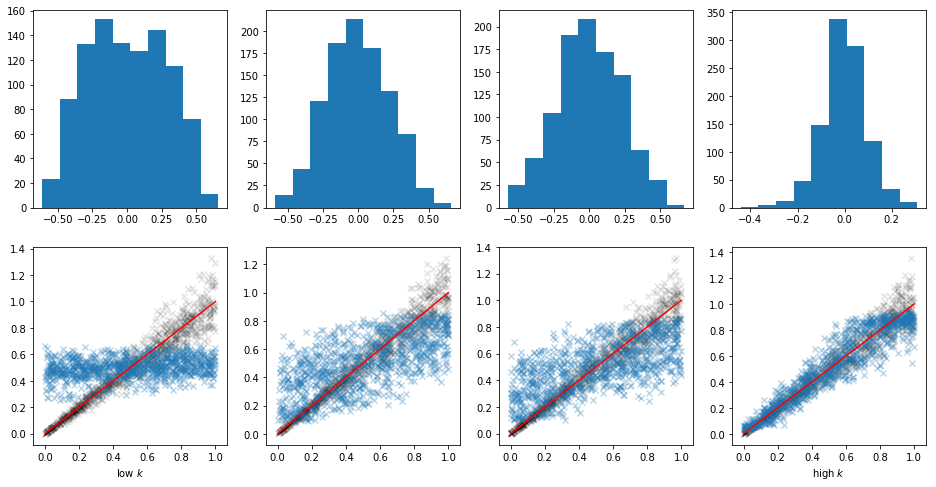

In [28]:
cnn_pred = array([mean(p["samples"],axis=0) for p in model.predict(testing_fn_generator(x_test, p_test))])/2+.5
ps_pred = array([dynamic_ps(x,253)[1] for x in x_test])
f,ax=subplots(2,nbands,figsize=(4*nbands,8))
for i in range(nbands):
    ax[0,i].hist(cnn_pred[:,i]-p_test[:,i])
    ax[1,i].plot([0,1],[0,1],c="r")
    ax[1,i].scatter(p_test[:,i],ps_pred[:,i],marker="x",alpha=0.1,c="k")
    ax[1,i].scatter(p_test[:,i],cnn_pred[:,i],marker="x",alpha=0.3)
ax[1,0].set_xlabel("low $k$")
ax[1,-1].set_xlabel("high $k$")

In [29]:
pred = model.predict(testing_fn_generator(x_test, p_test*2-1))
p=next(pred)
k=0

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /global/cscratch1/sd/avirukt/models/bp6/model.ckpt-62500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


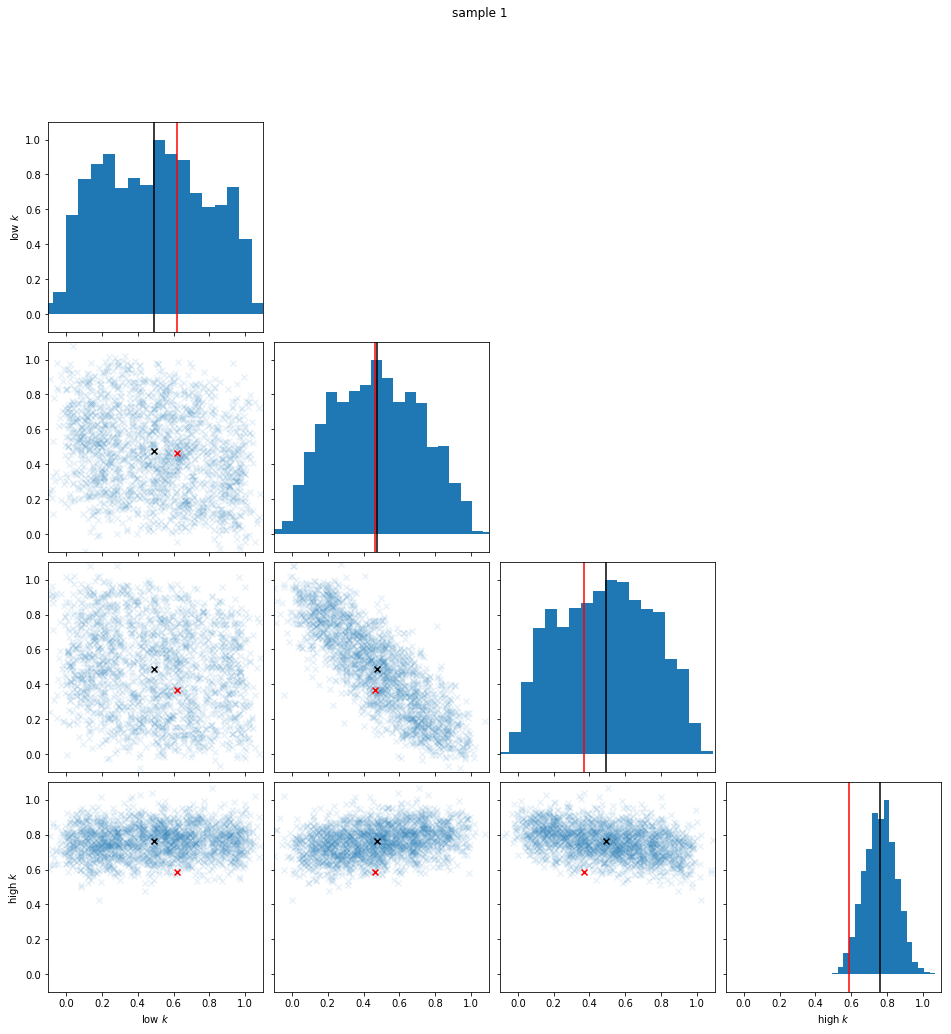

In [30]:
f,ax = subplots(nbands,nbands,sharex=True,sharey=True,gridspec_kw={"hspace": 0.05, "wspace": 0.05},figsize=(4*nbands,4*nbands))
suptitle(f"sample {k+1}")
samples= p["samples"]/2+.5
mn_s = mean(samples,axis=0)
for i in range(nbands):
    ax[i,i].set_ylim(-.1,1.1)
    ax[i,i].set_xlim(-.1,1.1)
    counts,edges,patches=ax[i,i].hist(samples[:,i],bins=20)
    top = amax(counts)
    for count,patch in zip(counts,patches):
        patch.set_height(count/top)
    ax[i,i].axvline(x=mn_s[i],c="k")
    ax[i,i].axvline(x=p_test[k,i],c="r")
    for j in range(i):
        ax[i,j].scatter(samples[:,j],samples[:,i],marker="x",alpha=0.1)
        ax[i,j].scatter(p_test[k,j],p_test[k,i],marker="x",c="r")
        ax[i,j].scatter(mn_s[j],mn_s[i],marker="x",c="k")
        ax[-(i+1),-(j+1)].axis("off")
ax[-1,0].set_xlabel("low $k$")
ax[-1,-1].set_xlabel("high $k$")
ax[0,0].set_ylabel("low $k$")
ax[-1,0].set_ylabel("high $k$")
p=next(pred)
k+=1

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /global/cscratch1/sd/avirukt/models/bp6/model.ckpt-62500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


Text(0.5, 0, 'high $k$')

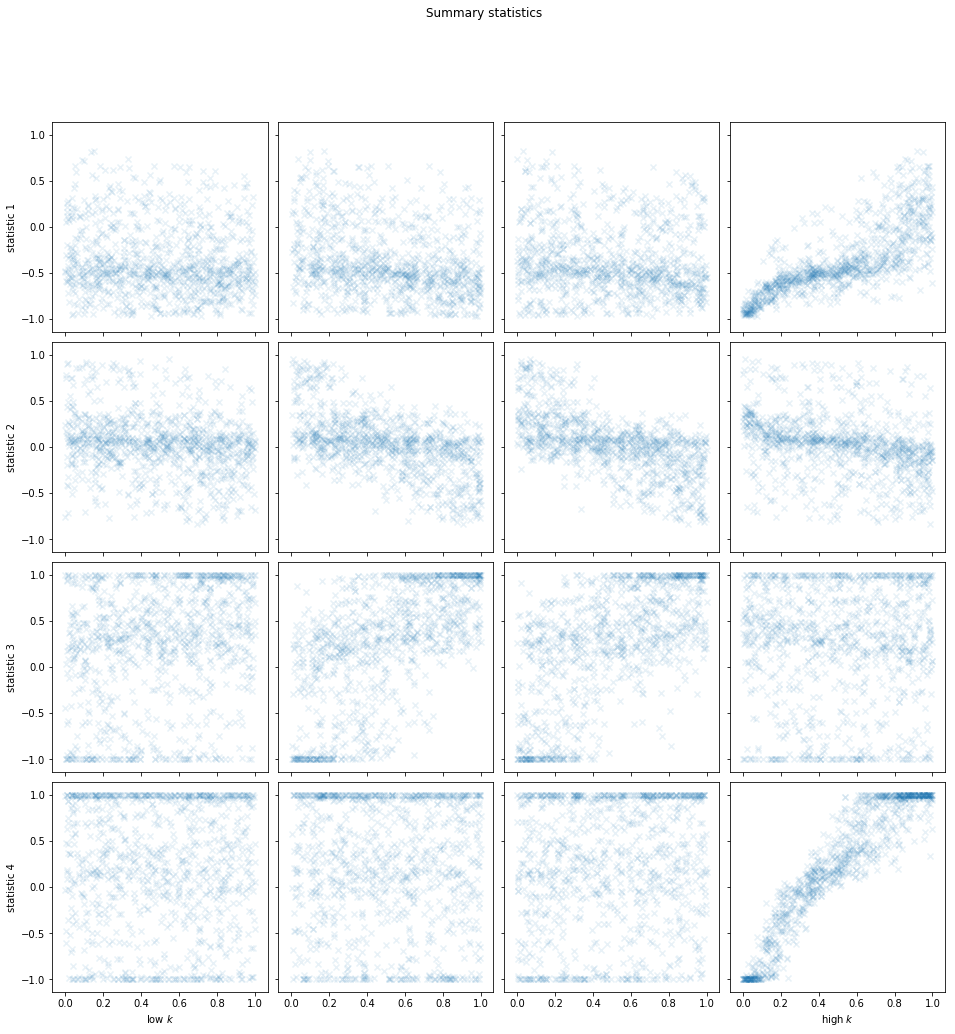

In [31]:
stats = array([p["stat"] for p in model.predict(testing_fn_generator(x_test, p_test))])
f,ax = subplots(nbands,nbands,sharex=True,sharey=True,gridspec_kw={"hspace": 0.05, "wspace": 0.05},figsize=(4*nbands,4*nbands))
#statlabels
suptitle("Summary statistics")
for i in range(nbands):
    for j in range(nbands):
        ax[i,j].scatter(p_test[:,j],stats[:,i],marker="x",alpha=0.1)
for i in range(nbands):
    ax[i,0].set_ylabel(f"statistic {i+1}")
ax[-1,0].set_xlabel("low $k$")
ax[-1,-1].set_xlabel("high $k$")

In [32]:
class bandpowers_v5_4b(tf.estimator.Estimator):
    def __init__(self,
                feature_columns,
                label_columns,
                n_mixture=10,
                diag=False,
                optimizer=tf.train.AdamOptimizer,
                activation_fn=tf.nn.relu,
                normalizer_fn=tf.contrib.layers.batch_norm,
                dropout=None,
                model_dir=None,
                config=None):

        def _model_fn(features, labels, mode):
            training=mode == tf.estimator.ModeKeys.TRAIN
            # Builds the neural network
            conv = tf.layers.conv2d(tf.reshape(features,(-1,32,32,1)), 4, 2, strides=2, activation=tf.nn.leaky_relu)
            conv = tf.layers.conv2d(conv, 16, 2, strides=2, activation=tf.nn.leaky_relu)
            conv = tf.layers.conv2d(conv, 64, 2, strides=2, activation=tf.nn.leaky_relu)
            conv = tf.layers.conv2d(conv, 256, 2, strides=2, activation=tf.nn.leaky_relu)
            conv = tf.reshape(tf.layers.conv2d(conv, 1024, 2, strides=2, activation=tf.nn.leaky_relu),(-1,1024))
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(conv,rate=0.2,training=training),512,activation_fn=tf.nn.leaky_relu)
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(conv,rate=0.2,training=training),128,activation_fn=tf.nn.leaky_relu)
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=0.2,training=training),32,activation_fn=tf.nn.leaky_relu)
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=0.2,training=training),8,activation_fn=tf.nn.leaky_relu)
            stat = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=0.2,training=training),4,activation_fn=tf.nn.tanh)
            
            net = tf.contrib.layers.fully_connected(stat, 128, activation_fn=tf.nn.leaky_relu)
            
                # Size of the covariance matrix
            label_dimension = len(label_columns)
            if diag ==True:
                size_sigma = label_dimension
            else:
                size_sigma = (label_dimension *(label_dimension +1) // 2)

            # Create mixture components from network output
            out_mu = tf.contrib.layers.fully_connected(net, label_dimension*n_mixture , activation_fn=None)
            out_mu = tf.reshape(out_mu, (-1, n_mixture, label_dimension))

            out_sigma = tf.contrib.layers.fully_connected(net, size_sigma * n_mixture, activation_fn=None)
            out_sigma = tf.reshape(out_sigma, (-1, n_mixture, size_sigma))

            out_p = tf.contrib.layers.fully_connected(net, n_mixture, activation_fn=None)

            if diag == True:
                sigma_mat = tf.nn.softplus(out_sigma)+1e-4
                gmm = tfp.distributions.MixtureSameFamily(mixture_distribution=tfp.distributions.Categorical(logits=out_p),
                              components_distribution=tfp.distributions.MultivariateNormalDiag(loc=out_mu,
                                                                                scale_diag=sigma_mat))
            else:
                sigma_mat = tfp.distributions.matrix_diag_transform(tfp.distributions.fill_triangular(out_sigma), transform=tf.nn.softplus)
                gmm = tfp.distributions.MixtureSameFamily(mixture_distribution=tfp.distributions.Categorical(logits=out_p),
                             components_distribution=tfp.distributions.MultivariateNormalTriL(loc=out_mu,
                                                                                scale_tril=sigma_mat))

            predictions = {'mu': out_mu, 'sigma': sigma_mat, 'p':out_p, 'stat':stat}

            if mode == tf.estimator.ModeKeys.PREDICT:
                y = gmm.sample(2000)
                samples = y
                predictions['samples'] = tf.transpose(y,[1,0,2])

                return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions,
                                                  export_outputs={'pdf': tf.estimator.export.PredictOutput(predictions),
                                                                  'samples': tf.estimator.export.PredictOutput(samples),
                                                                  tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY: tf.estimator.export.PredictOutput(samples)})
            label_layer = labels

            # Compute and register loss function
            loss = - tf.reduce_mean(gmm.log_prob(label_layer),axis=0)
            tf.losses.add_loss(loss)
            total_loss = tf.losses.get_total_loss(add_regularization_losses=True)

            train_op = None
            eval_metric_ops = None

            # Define optimizer
            if mode == tf.estimator.ModeKeys.TRAIN:
                update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
                with tf.control_dependencies(update_ops):
                    train_op = optimizer(learning_rate=0.0002).minimize(loss=total_loss,
                                                global_step=tf.train.get_global_step())
                tf.summary.scalar('loss', loss)
            elif mode == tf.estimator.ModeKeys.EVAL:
                eval_metric_ops = { "log_p": loss}

            return tf.estimator.EstimatorSpec(mode=mode,
                                              predictions=predictions,
                                              loss=total_loss,
                                              train_op=train_op,
                                              eval_metric_ops=eval_metric_ops)

        super(self.__class__, self).__init__(model_fn=_model_fn,
                                             model_dir=model_dir,
                                             config=config)
    
model = bandpowers_v5_4b(["field"], ["low k","x","y","high k"], model_dir='/global/cscratch1/sd/avirukt/models/bp9')
batch_size=32
model.train(training_fn_generator(x_train, p_train-.5),max_steps=20*nsims_train//batch_size)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/global/cscratch1/sd/avirukt/models/bp9', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x2aaaf82a00b8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Skipping training since max_steps has already saved.


In [33]:
cnn_pred = array([mean(p["samples"],axis=0) for p in model.predict(testing_fn_generator(x_test, p_test))])+.5
#ps_pred = array([dynamic_ps(x,253)[1] for x in x_test])
f,ax=subplots(2,nbands,figsize=(4*nbands,8))
for i in range(nbands):
    ax[0,i].hist(cnn_pred[:,i]-p_test[:,i])
    ax[1,i].plot([0,1],[0,1],c="r")
    ax[1,i].scatter(p_test[:,i],ps_pred[:,i],marker="x",alpha=0.1,c="k")
    ax[1,i].scatter(p_test[:,i],cnn_pred[:,i],marker="x",alpha=0.2)
ax[1,0].set_xlabel("low $k$")
ax[1,-1].set_xlabel("high $k$")

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /global/cscratch1/sd/avirukt/models/bp9/model.ckpt-62500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


Text(0.5, 0, 'high $k$')

In [34]:
pred = model.predict(testing_fn_generator(x_test, p_test))
p=next(pred)
k=0

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /global/cscratch1/sd/avirukt/models/bp9/model.ckpt-62500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [35]:
f,ax = subplots(nbands,nbands,sharex=True,sharey=True,gridspec_kw={"hspace": 0.05, "wspace": 0.05},figsize=(4*nbands,4*nbands))
suptitle(f"sample {k+1}")
samples= p["samples"]+.5
mn_s = mean(samples,axis=0)
for i in range(nbands):
    ax[i,i].set_ylim(-.1,1.1)
    ax[i,i].set_xlim(-.1,1.1)
    counts,edges,patches=ax[i,i].hist(samples[:,i],bins=20)
    top = amax(counts)
    for count,patch in zip(counts,patches):
        patch.set_height(count/top)
    ax[i,i].axvline(x=mn_s[i],c="k")
    ax[i,i].axvline(x=p_test[k,i],c="r")
    for j in range(i):
        ax[i,j].scatter(samples[:,j],samples[:,i],marker="x",alpha=0.1)
        ax[i,j].scatter(p_test[k,j],p_test[k,i],marker="x",c="r")
        ax[i,j].scatter(mn_s[j],mn_s[i],marker="x",c="k")
        ax[-(i+1),-(j+1)].axis("off")
ax[-1,0].set_xlabel("low $k$")
ax[-1,-1].set_xlabel("high $k$")
ax[0,0].set_ylabel("low $k$")
ax[-1,0].set_ylabel("high $k$")
p=next(pred)
k+=1

In [19]:
class bandpowers_v6_4b(tf.estimator.Estimator):
    def __init__(self,
                feature_columns,
                label_columns,
                n_mixture=10,
                diag=False,
                optimizer=tf.train.AdamOptimizer,
                activation_fn=tf.nn.relu,
                normalizer_fn=tf.contrib.layers.batch_norm,
                dropout=None,
                model_dir=None,
                config=None):

        def _model_fn(features, labels, mode):
            training=mode == tf.estimator.ModeKeys.TRAIN
            # Builds the neural network
            conv = tf.layers.conv2d(tf.reshape(features,(-1,32,32,1)), 4, 2, strides=2, activation=tf.nn.leaky_relu)
            conv = tf.layers.conv2d(conv, 16, 2, strides=2, activation=tf.nn.leaky_relu)
            conv = tf.layers.conv2d(conv, 64, 2, strides=2, activation=tf.nn.leaky_relu)
            conv = tf.layers.conv2d(conv, 256, 2, strides=2, activation=tf.nn.leaky_relu)
            conv = tf.reshape(tf.layers.conv2d(conv, 1024, 2, strides=2, activation=tf.nn.leaky_relu),(-1,1024))
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(conv,rate=0.2,training=training),512,activation_fn=tf.nn.tanh)
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(conv,rate=0.2,training=training),128,activation_fn=tf.nn.leaky_relu)
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=0.2,training=training),32,activation_fn=tf.nn.leaky_relu)
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=0.2,training=training),8,activation_fn=tf.nn.leaky_relu)
            stat = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=0.2,training=training),4,activation_fn=tf.nn.tanh)
            
            net = tf.contrib.layers.fully_connected(stat, 128, activation_fn=tf.nn.leaky_relu)
            
                # Size of the covariance matrix
            label_dimension = len(label_columns)
            if diag ==True:
                size_sigma = label_dimension
            else:
                size_sigma = (label_dimension *(label_dimension +1) // 2)

            # Create mixture components from network output
            out_mu = tf.contrib.layers.fully_connected(net, label_dimension*n_mixture , activation_fn=None)
            out_mu = tf.reshape(out_mu, (-1, n_mixture, label_dimension))

            out_sigma = tf.contrib.layers.fully_connected(net, size_sigma * n_mixture, activation_fn=None)
            out_sigma = tf.reshape(out_sigma, (-1, n_mixture, size_sigma))

            out_p = tf.contrib.layers.fully_connected(net, n_mixture, activation_fn=None)

            if diag == True:
                sigma_mat = tf.nn.softplus(out_sigma)+1e-4
                gmm = tfp.distributions.MixtureSameFamily(mixture_distribution=tfp.distributions.Categorical(logits=out_p),
                              components_distribution=tfp.distributions.MultivariateNormalDiag(loc=out_mu,
                                                                                scale_diag=sigma_mat))
            else:
                sigma_mat = tfp.distributions.matrix_diag_transform(tfp.distributions.fill_triangular(out_sigma), transform=tf.nn.softplus)
                gmm = tfp.distributions.MixtureSameFamily(mixture_distribution=tfp.distributions.Categorical(logits=out_p),
                             components_distribution=tfp.distributions.MultivariateNormalTriL(loc=out_mu,
                                                                                scale_tril=sigma_mat))

            predictions = {'mu': out_mu, 'sigma': sigma_mat, 'p':out_p, 'stat':stat}

            if mode == tf.estimator.ModeKeys.PREDICT:
                y = gmm.sample(2000)
                samples = y
                predictions['samples'] = tf.transpose(y,[1,0,2])

                return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions,
                                                  export_outputs={'pdf': tf.estimator.export.PredictOutput(predictions),
                                                                  'samples': tf.estimator.export.PredictOutput(samples),
                                                                  tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY: tf.estimator.export.PredictOutput(samples)})
            label_layer = labels

            # Compute and register loss function
            loss = - tf.reduce_mean(gmm.log_prob(label_layer),axis=0)
            tf.losses.add_loss(loss)
            total_loss = tf.losses.get_total_loss(add_regularization_losses=True)

            train_op = None
            eval_metric_ops = None

            # Define optimizer
            if mode == tf.estimator.ModeKeys.TRAIN:
                update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
                with tf.control_dependencies(update_ops):
                    train_op = optimizer(learning_rate=0.0002).minimize(loss=total_loss,
                                                global_step=tf.train.get_global_step())
                tf.summary.scalar('loss', loss)
            elif mode == tf.estimator.ModeKeys.EVAL:
                eval_metric_ops = { "log_p": loss}

            return tf.estimator.EstimatorSpec(mode=mode,
                                              predictions=predictions,
                                              loss=total_loss,
                                              train_op=train_op,
                                              eval_metric_ops=eval_metric_ops)

        super(self.__class__, self).__init__(model_fn=_model_fn,
                                             model_dir=model_dir,
                                             config=config)
    
model = bandpowers_v6_4b(["field"], ["low k","x","y","high k"], model_dir='/global/cscratch1/sd/avirukt/models/bp10')
batch_size=32
model.train(training_fn_generator(x_train, (p_train-.5)*2),max_steps=40*nsims_train//batch_size)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/global/cscratch1/sd/avirukt/models/bp10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x2aab64eb0710>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.


KeyboardInterrupt: 

In [20]:
cnn_pred = array([mean(p["samples"],axis=0) for p in model.predict(testing_fn_generator(x_test, p_test))])/2+.5
ps_pred = array([dynamic_ps(x,253)[1] for x in x_test])
f,ax=subplots(2,nbands,figsize=(4*nbands,8))
for i in range(nbands):
    ax[0,i].hist(cnn_pred[:,i]-p_test[:,i])
    ax[1,i].plot([0,1],[0,1],c="r")
    ax[1,i].scatter(p_test[:,i],ps_pred[:,i],marker="x",alpha=0.1,c="k")
    ax[1,i].scatter(p_test[:,i],cnn_pred[:,i],marker="x",alpha=0.2)
ax[1,0].set_xlabel("low $k$")
ax[1,-1].set_xlabel("high $k$")

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /global/cscratch1/sd/avirukt/models/bp10/model.ckpt-31250
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


Text(0.5, 0, 'high $k$')

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /global/cscratch1/sd/avirukt/models/bp10/model.ckpt-62500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


Text(0.5, 0, 'high $k$')

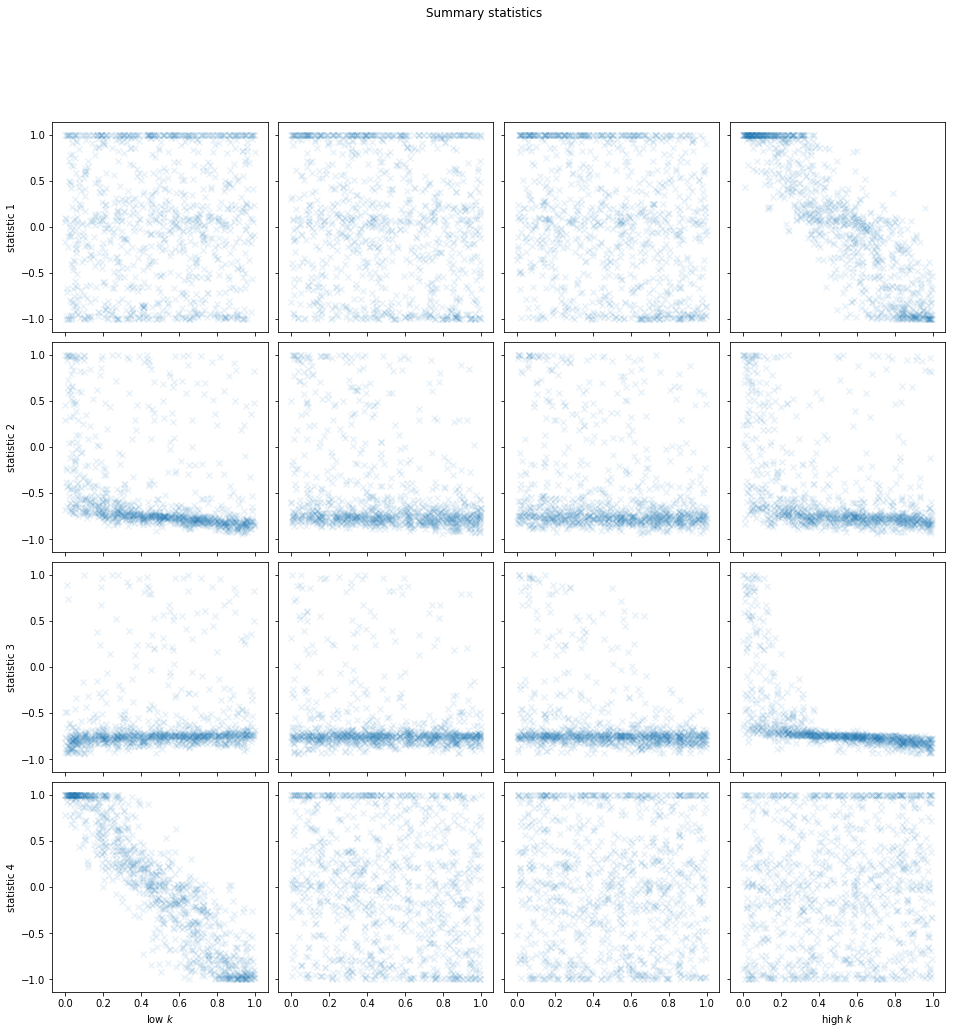

In [54]:
stats = array([p["stat"] for p in model.predict(testing_fn_generator(x_test, p_test))])
f,ax = subplots(nbands,nbands,sharex=True,sharey=True,gridspec_kw={"hspace": 0.05, "wspace": 0.05},figsize=(4*nbands,4*nbands))
#statlabels
suptitle("Summary statistics")
for i in range(nbands):
    for j in range(nbands):
        ax[i,j].scatter(p_test[:,j],stats[:,i],marker="x",alpha=0.1)
for i in range(nbands):
    ax[i,0].set_ylabel(f"statistic {i+1}")
ax[-1,0].set_xlabel("low $k$")
ax[-1,-1].set_xlabel("high $k$")

In [24]:
pred = model.predict(testing_fn_generator(x_test, p_test))
p=next(pred)
k=0

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /global/cscratch1/sd/avirukt/models/bp10/model.ckpt-62500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [53]:
f,ax = subplots(nbands,nbands,sharex=True,sharey=True,gridspec_kw={"hspace": 0.05, "wspace": 0.05},figsize=(4*nbands,4*nbands))
ps_point = dynamic_ps(x_test[k],253)[1]
suptitle(f"sample {k+1}")
samples= p["samples"]/2+.5
#mn_s = p["map"]/2+.5
mn_s = mean(samples,axis=0)
for i in range(nbands):
    ax[i,i].set_ylim(-.1,1.1)
    ax[i,i].set_xlim(-.1,1.1)
    counts,edges,patches=ax[i,i].hist(samples[:,i],bins=20)
    top = amax(counts)
    for count,patch in zip(counts,patches):
        patch.set_height(count/top)
    ax[i,i].axvline(x=ps_point[i],c="g")
    ax[i,i].axvline(x=mn_s[i],c="k")
    ax[i,i].axvline(x=p_test[k,i],c="r")
    for j in range(i):
        ax[i,j].scatter(samples[:,j],samples[:,i],marker="x",alpha=0.1)
        ax[i,j].scatter(ps_point[j],ps_point[i],marker="x",c="g")
        ax[i,j].scatter(p_test[k,j],p_test[k,i],marker="x",c="r")
        ax[i,j].scatter(mn_s[j],mn_s[i],marker="x",c="k")
        ax[-(i+1),-(j+1)].axis("off")
ax[-1,0].set_xlabel("low $k$")
ax[-1,-1].set_xlabel("high $k$")
ax[0,0].set_ylabel("low $k$")
ax[-1,0].set_ylabel("high $k$")
p=next(pred)
k+=1

In [55]:
class bandpowers_v7_4b(tf.estimator.Estimator):
    def __init__(self,
                feature_columns,
                label_columns,
                n_mixture=10,
                diag=False,
                optimizer=tf.train.AdamOptimizer,
                activation_fn=tf.nn.relu,
                normalizer_fn=tf.contrib.layers.batch_norm,
                dropout=None,
                model_dir=None,
                config=None):

        def _model_fn(features, labels, mode):
            training=mode == tf.estimator.ModeKeys.TRAIN
            # Builds the neural network
            conv = tf.layers.conv2d(tf.reshape(features,(-1,32,32,1)), 4, 2, strides=2, activation=tf.nn.leaky_relu)
            conv = tf.layers.conv2d(conv, 16, 2, strides=2, activation=tf.nn.leaky_relu)
            conv = tf.layers.conv2d(conv, 64, 2, strides=2, activation=tf.nn.leaky_relu)
            conv = tf.layers.conv2d(conv, 256, 2, strides=2, activation=tf.nn.leaky_relu)
            conv = tf.reshape(tf.layers.conv2d(conv, 1024, 2, strides=2, activation=tf.nn.leaky_relu),(-1,1024))
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(conv,rate=0.2,training=training),512,activation_fn=tf.nn.leaky_relu)
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(conv,rate=0.2,training=training),128,activation_fn=tf.nn.leaky_relu)
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=0.2,training=training),32,activation_fn=tf.nn.leaky_relu)
            dense = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=0.2,training=training),8,activation_fn=tf.nn.leaky_relu)
            stat = tf.contrib.layers.fully_connected(tf.layers.dropout(dense,rate=0.2,training=training),4,activation_fn=tf.nn.leaky_relu)
            
            net = tf.contrib.layers.fully_connected(stat, 128, activation_fn=tf.nn.leaky_relu)
            
                # Size of the covariance matrix
            label_dimension = len(label_columns)
            if diag ==True:
                size_sigma = label_dimension
            else:
                size_sigma = (label_dimension *(label_dimension +1) // 2)

            # Create mixture components from network output
            out_mu = tf.contrib.layers.fully_connected(net, label_dimension*n_mixture , activation_fn=None)
            out_mu = tf.reshape(out_mu, (-1, n_mixture, label_dimension))

            out_sigma = tf.contrib.layers.fully_connected(net, size_sigma * n_mixture, activation_fn=None)
            out_sigma = tf.reshape(out_sigma, (-1, n_mixture, size_sigma))

            out_p = tf.contrib.layers.fully_connected(net, n_mixture, activation_fn=None)

            if diag == True:
                sigma_mat = tf.nn.softplus(out_sigma)+1e-4
                gmm = tfp.distributions.MixtureSameFamily(mixture_distribution=tfp.distributions.Categorical(logits=out_p),
                              components_distribution=tfp.distributions.MultivariateNormalDiag(loc=out_mu,
                                                                                scale_diag=sigma_mat))
            else:
                sigma_mat = tfp.distributions.matrix_diag_transform(tfp.distributions.fill_triangular(out_sigma), transform=tf.nn.softplus)
                gmm = tfp.distributions.MixtureSameFamily(mixture_distribution=tfp.distributions.Categorical(logits=out_p),
                             components_distribution=tfp.distributions.MultivariateNormalTriL(loc=out_mu,
                                                                                scale_tril=sigma_mat))

            predictions = {'mu': out_mu, 'sigma': sigma_mat, 'p':out_p, 'stat':stat}

            if mode == tf.estimator.ModeKeys.PREDICT:
                y = gmm.sample(2000)
                samples = y
                predictions['samples'] = tf.transpose(y,[1,0,2])

                return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions,
                                                  export_outputs={'pdf': tf.estimator.export.PredictOutput(predictions),
                                                                  'samples': tf.estimator.export.PredictOutput(samples),
                                                                  tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY: tf.estimator.export.PredictOutput(samples)})
            label_layer = labels

            # Compute and register loss function
            loss = - tf.reduce_mean(gmm.log_prob(label_layer),axis=0)
            tf.losses.add_loss(loss)
            total_loss = tf.losses.get_total_loss(add_regularization_losses=True)

            train_op = None
            eval_metric_ops = None

            # Define optimizer
            if mode == tf.estimator.ModeKeys.TRAIN:
                update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
                with tf.control_dependencies(update_ops):
                    train_op = optimizer(learning_rate=0.0002).minimize(loss=total_loss,
                                                global_step=tf.train.get_global_step())
                tf.summary.scalar('loss', loss)
            elif mode == tf.estimator.ModeKeys.EVAL:
                eval_metric_ops = { "log_p": loss}

            return tf.estimator.EstimatorSpec(mode=mode,
                                              predictions=predictions,
                                              loss=total_loss,
                                              train_op=train_op,
                                              eval_metric_ops=eval_metric_ops)

        super(self.__class__, self).__init__(model_fn=_model_fn,
                                             model_dir=model_dir,
                                             config=config)
    
model = bandpowers_v7_4b(["field"], ["low k","x","y","high k"], model_dir='/global/cscratch1/sd/avirukt/models/bp11')
batch_size=32
model.train(training_fn_generator(x_train, (p_train-.5)*2),max_steps=20*nsims_train//batch_size)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/global/cscratch1/sd/avirukt/models/bp11', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x2aab6417eac8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.


In [56]:
cnn_pred = array([mean(p["samples"],axis=0) for p in model.predict(testing_fn_generator(x_test, p_test))])/2+.5
ps_pred = array([dynamic_ps(x,253)[1] for x in x_test])
f,ax=subplots(2,nbands,figsize=(4*nbands,8))
for i in range(nbands):
    ax[0,i].hist(cnn_pred[:,i]-p_test[:,i])
    ax[1,i].plot([0,1],[0,1],c="r")
    ax[1,i].scatter(p_test[:,i],ps_pred[:,i],marker="x",alpha=0.1,c="k")
    ax[1,i].scatter(p_test[:,i],cnn_pred[:,i],marker="x",alpha=0.2)
ax[1,0].set_xlabel("low $k$")
ax[1,-1].set_xlabel("high $k$")

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /global/cscratch1/sd/avirukt/models/bp11/model.ckpt-62500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


Text(0.5, 0, 'high $k$')

In [58]:
stats = array([p["stat"] for p in model.predict(testing_fn_generator(x_test, p_test))])
f,ax = subplots(nbands,nbands,sharex=True,sharey=True,gridspec_kw={"hspace": 0.05, "wspace": 0.05},figsize=(4*nbands,4*nbands))
#statlabels
suptitle("Summary statistics")
for i in range(nbands):
    for j in range(nbands):
        ax[i,j].scatter(p_test[:,j],stats[:,i],marker="x",alpha=0.1)
for i in range(nbands):
    ax[i,0].set_ylabel(f"statistic {i+1}")
    ax[i,0].set_ylim(-2,2)
ax[-1,0].set_xlabel("low $k$")
ax[-1,-1].set_xlabel("high $k$")

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /global/cscratch1/sd/avirukt/models/bp11/model.ckpt-62500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


Text(0.5, 0, 'high $k$')

In [59]:
pred = model.predict(testing_fn_generator(x_test, p_test))
p=next(pred)
k=0

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /global/cscratch1/sd/avirukt/models/bp11/model.ckpt-62500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [66]:
f,ax = subplots(nbands,nbands,sharex=True,sharey=True,gridspec_kw={"hspace": 0.05, "wspace": 0.05},figsize=(4*nbands,4*nbands))
ps_point = dynamic_ps(x_test[k],253)[1]
suptitle(f"sample {k+1}")
samples= p["samples"]/2+.5
#mn_s = p["map"]/2+.5
mn_s = mean(samples,axis=0)
for i in range(nbands):
    ax[i,i].set_ylim(-.1,1.1)
    ax[i,i].set_xlim(-.1,1.1)
    counts,edges,patches=ax[i,i].hist(samples[:,i],bins=20)
    top = amax(counts)
    for count,patch in zip(counts,patches):
        patch.set_height(count/top)
    ax[i,i].axvline(x=ps_point[i],c="g")
    ax[i,i].axvline(x=mn_s[i],c="k")
    ax[i,i].axvline(x=p_test[k,i],c="r")
    for j in range(i):
        ax[i,j].scatter(samples[:,j],samples[:,i],marker="x",alpha=0.1)
        ax[i,j].scatter(ps_point[j],ps_point[i],marker="x",c="g")
        ax[i,j].scatter(p_test[k,j],p_test[k,i],marker="x",c="r")
        ax[i,j].scatter(mn_s[j],mn_s[i],marker="x",c="k")
        ax[-(i+1),-(j+1)].axis("off")
ax[-1,0].set_xlabel("low $k$")
ax[-1,-1].set_xlabel("high $k$")
ax[0,0].set_ylabel("low $k$")
ax[-1,0].set_ylabel("high $k$")
p=next(pred)
k+=1